In [1]:
!XLA_FLAGS=--xla_gpu_cuda_data_dir=/cm/shared/sw/pkg/devel/cuda/10.1.243_418.87.00

In [2]:
import jax
print("jax version: ", jax.__version__)
import jax.numpy as np
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz

rng = jax.random.PRNGKey(2)

jax version:  0.2.10


In [40]:
cd ~/repositories/scratch/devinstall/imnn

/mnt/home/tmakinen/repositories/scratch/devinstall/imnn


In [41]:
!git checkout dev

M	imnn/imnn/_aggregated_imnn.py
Already on 'dev'


In [7]:
!git pull

Updating a7d02f9..ac3f2a3
Fast-forward
 Jenkinsfile                                        |   23 +-
 README.rst                                         |  628 -------
 clear_test_files.sh                                |    3 +
 docs/index.rst                                     |    1 +
 docs/pages/examples.rst                            |    7 +
 .../AggregatedGradientIMNN.rst                     |  225 +++
 .../AggregatedGradientIMNN/output_28_0.png         |  Bin 0 -> 45851 bytes
 .../AggregatedNumericalGradientIMNN.rst            |  231 +++
 .../output_26_0.png                                |  Bin 0 -> 45573 bytes
 .../AggregatedSimulatorIMNN.rst                    |  189 ++
 .../AggregatedSimulatorIMNN/output_23_0.png        |  Bin 0 -> 59212 bytes
 .../DatasetNumericalGradientIMNN.rst               |  516 ++++++
 .../DatasetNumericalGradientIMNN/output_31_0.png   |  Bin 0 -> 47691 bytes
 docs/pages/examples/GradientIMNN/GradientIMNN.rst  |  210 +++
 docs/pages/examples/Gradien

In [42]:
!python -m pip install -e .

Obtaining file:///mnt/home/tmakinen/repositories/scratch/devinstall/imnn
  Attempting uninstall: IMNN
    Found existing installation: IMNN 0.3.dev0
    Uninstalling IMNN-0.3.dev0:
      Successfully uninstalled IMNN-0.3.dev0
  Running setup.py develop for IMNN


In [3]:
print(tfp.__version__)

0.12.1


In [4]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [5]:
import IMNN.experimental.jax.lfi

In [6]:
# for model stuff
import jax.experimental.optimizers as optimizers
import jax.experimental.stax as stax
from jax import jit

# for imnn
import imnn
print("IMNN version: ", imnn.__version__)

from imnn.imnn import (
    AggregatedGradientIMNN,
    AggregatedNumericalGradientIMNN,
    AggregatedSimulatorIMNN,
    GradientIMNN,
    NumericalGradientIMNN,
    SimulatorIMNN,
)
from imnn.lfi import (
    ApproximateBayesianComputation,
    GaussianApproximation,
)
from imnn.utils import value_and_jacrev, value_and_jacfwd

rng = jax.random.PRNGKey(0)

IMNN version:  0.3dev


In [7]:
N = 20

In [8]:
def scipy_compute_r2(N):
    _Di = np.tile(toeplitz(np.arange(N)), (N, N))
    _Dj = np.concatenate(
        [np.concatenate(
            [np.tile(np.abs(i - j),(N, N)) 
             for i in range(N)], 
            axis=0)
         for j in range(N)],
        axis=1)
    _distance_squared = _Di * _Di + _Dj * _Dj
    return _distance_squared

def compute_r2(N):
    _r2 = np.tile(np.abs(np.expand_dims(np.arange(N), 0) 
                    - np.expand_dims(np.arange(N), 1)), (N, N)) ** 2. + np.abs(np.expand_dims(np.repeat(np.arange(N), N), 0) 
                             - np.expand_dims(np.repeat(np.arange(N), N), 1)) ** 2.
    return _r2

r2 = compute_r2(N).astype(np.float32)

def ξ_G(β):
    return np.exp(
        -np.expand_dims(r2, tuple(np.arange(β.ndim))) 
        / 4. / np.expand_dims(β, (-2, -1))**2.)

def get_G_field(β):
    pass

def fill_zeros(k, value):
    from functools import partial

    def fnk(k):
        return jax.lax.cond(np.less_equal(k, 1e-5), lambda _: value, lambda k: k+value, operand=k)

    if len(k.shape) == 1:
        return jax.vmap(fnk)(k)
    else:
        return jax.vmap(partial(fill_zeros, value=value))(k)


def xi_LN(r, α, β, PixelNoise=0.01):

    xi = 1/(np.power(α+1e-12,2)) * (np.exp(np.power(α,2)*np.exp(-0.25*np.power(r/β,2))) - 1)

    # Add pixel noise at zero separation:

    xi = fill_zeros(xi, PixelNoise**2)
    #xi[np.where(r<1e-5)] += PixelNoise**2

    return xi

In [9]:
# derivatives of corr function

In [10]:
def dxi_LN_dalpha(r, α, β):

    _deriv =  2/(α+1e-12) * np.exp(-0.25*np.power(r/β,2)) * np.exp(np.power(α,2)*np.exp(-0.25*np.power(r/β,2))) - 2/np.power(α+1e-12,3) * (np.exp(np.power(α,2)*np.exp(-0.25*np.power(r/β,2))) - 1)
    return _deriv

def dxi_LN_dbeta(r, β, α):

    return (0.5*np.power(r, 2) * np.exp(np.power(α, 2) * np.exp(-0.25 * np.power(r/β,2)) - 0.25*np.power(r/β,2)))*np.power(1./β,3)

In [11]:
def _f_NL(_α, _β):
      return tfd.JointDistributionNamed(
        dict(α = tfd.Uniform(low=0.0, high=2.0), β = tfd.Uniform(low=0.2, high=0.8),
             f_NL = tfd.TransformedDistribution(
               distribution=tfd.MultivariateNormalTriL(loc=np.zeros((N**2,)),
                 scale_tril=np.linalg.cholesky(ξ_G(_β))),
               bijector=tfb.Chain([tfb.Scale(1. / np.expand_dims(_α, (-1))), tfb.Expm1(),
                                   tfb.AffineScalar(shift=-0.5 * np.expand_dims(_α, -1)**2.,
                                                    scale=np.expand_dims(_α, -1))]))))

In [12]:
def simulator1(rng, n, 
        α, β, μ=np.zeros((N**2,), dtype=np.float32), 
        σ=np.ones((N**2 * (N**2 + 1) // 2,), dtype=np.float32)):
    dist = _f_NL(α, β)
    if n is not None:
        return dist.sample(n, seed=rng)
    else: 
        return dist.sample(seed=rng)

In [13]:
f_NL = tfd.JointDistributionNamed(
    dict(
        α = tfd.Uniform(low=np.float32(0.), high=np.float32(2.)),
        β = tfd.Uniform(low=np.float32(0.2), high=np.float32(0.8)),
        μ = tfd.Normal(
            loc=np.zeros((N**2,), dtype=np.float32), 
            scale=np.ones((N**2,), dtype=np.float32)),                 
        σ = tfp.distributions.Uniform(
            low=np.zeros((N**2 * (N**2 + 1) // 2,), dtype=np.float32), 
            high=np.ones((N**2 * (N**2 + 1) // 2,), dtype=np.float32)),
        f_NL = lambda α, β, μ, σ: tfd.TransformedDistribution(
            #distribution=tfd.TransformedDistribution(
                distribution=tfd.MultivariateNormalTriL(
                    loc=μ, 
                    scale_tril=tfp.math.fill_triangular(σ) 
                        * np.linalg.cholesky(ξ_G(β))),
                #bijector=tfb.Reshape((N, N))),
#             bijector=tfb.Chain([
#                 tfb.Scale(np.expand_dims(α, (-1))),
#                 tfb.Shift(-np.float32(0.5) * np.expand_dims(α, (-1))**np.float32(2.)),
#                 tfb.Exp(),
#                 tfb.Shift(-np.float32(1.)),
#                 tfb.Scale(np.float32(1.) / np.expand_dims(α, (-1)))]
#                 ))))
        bijector=tfb.Chain([
                    tfb.Scale(np.float32(1.) / np.expand_dims(α, (-1))),
                    tfb.Expm1(),
                    tfb.AffineScalar(shift=-np.float32(0.5) * np.expand_dims(α, -1)**np.float32(2.), scale=np.expand_dims(α, -1))]))))

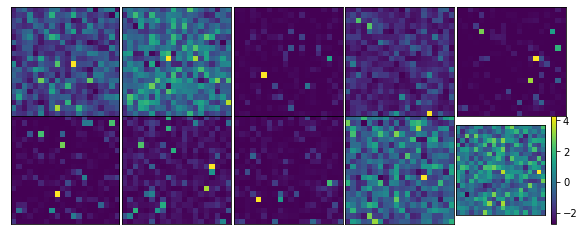

In [14]:
rng, key = jax.random.split(rng)
f_NLs = f_NL.sample(10, seed=key)["f_NL"].reshape((10, N, N))
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(2):
    for j in range(5):
        a = ax[i, j].imshow(f_NLs[j + i * 5])
        ax[i, j].set(xticks=[], yticks=[])
plt.colorbar(a)

# set up IMNN for problem

In [15]:
pad = 2 #2**2
input_shape = (1,1, N+pad*2,N+pad*2)
print('input shape: ', input_shape)
θ_fid = np.array([0.95, 0.55], dtype=np.float32)
# IMNN params
n_s = 5000
n_d = 5000
λ = 100.0
ϵ = 0.1

n_params = 2
n_summaries = 2

input shape:  (1, 1, 24, 24)


### compute known Fisher at fiducial 

In [16]:
Nsq = N**2
r = np.sqrt(r2)#[:Nsq//2, :Nsq//2]


def known_fisher(r, θ):
    α,β = θ
    
    # extract diagonal from matrix
    ξ_LN    = np.diag(xi_LN(r, α, β, PixelNoise=0.))
    # get derivatives
    dξ_dα   = dxi_LN_dalpha(r, α, β)
    dξ_dβ   = dxi_LN_dbeta(r, α, β)
    

    # reassign to a diagnonal matrix with zeros on off-diag
    Cinv = np.diag(1. / ξ_LN)          
    Ca =  (dξ_dα)           # C_{,A}
    Cb =  (dξ_dβ)           # C_{,B}
    
    # fisher matrix entries
    Faa = 0.5 * np.trace((Ca @ Cinv @ Ca @ Cinv))
    Fab = 0.5 * np.trace((Ca @ Cinv @ Cb @ Cinv))
    Fba = 0.5 * np.trace((Cb @ Cinv @ Ca @ Cinv))
    Fbb = 0.5 * np.trace((Cb @ Cinv @ Cb @ Cinv))

    return np.array([[Faa, Fab], [Fba, Fbb]])

In [17]:
f = known_fisher(r, θ_fid)
print(f)

analytic_detF = np.linalg.det(f)
print(analytic_detF)

[[254.7555   47.02849]
 [ 47.02849 998.3765 ]]
252130.06


## compute numerical fisher from distribution

In [18]:
def _f_NL(α, β):
    return tfd.TransformedDistribution(
        distribution=tfd.MultivariateNormalTriL(
            loc=np.zeros((N**2,)),
            scale_tril=np.linalg.cholesky(ξ_G(β))),
        bijector=tfb.Chain([
            tfb.Scale(1. / np.expand_dims(α, (-1))), 
            tfb.Expm1(),
            tfb.AffineScalar(
                shift=-0.5 * np.expand_dims(α, -1)**2.,
                scale=np.expand_dims(α, -1))]))

def score(α, β, key):
    f_NL = _f_NL(α, β)
    return f_NL.log_prob(f_NL.sample(seed=key))

@jax.jit
def dlnLdθ(α, β, key):
    return jax.grad(score, argnums=(0, 1))(α, β, key)

def numeric_F(α, β, key, n_samples):
    keys = np.array(jax.random.split(key, num=n_samples))
    return np.cov(np.array(jax.vmap(dlnLdθ)(np.repeat(α, n_samples), np.repeat(β, n_samples), keys)))


In [19]:
rng, key = jax.random.split(rng)
F_expected = numeric_F(np.array(.95), np.array(0.55), key, 50)
detF_expected = np.linalg.det(F_expected)

print('expected F: ', F_expected)
print('expected det F: ', detF_expected)

print('% difference from analytic F: ', np.abs(detF_expected - analytic_detF) / detF_expected)

expected F:  [[1497.5089 2342.6594]
 [2342.6594 3841.5532]]
expected det F:  264707.22
% difference from analytic F:  0.047513463


### simulator for IMNN

In [20]:
# Define a log_normal field class (Florent's paper -> JAX)
class LogNormalField:
    @staticmethod
    def compute_rsquared(nside):
        """
        Compute the correlation function of the underlying gaussian field
        
        Parameters:
            nside : int
                Image is nside x nside pixels
        """
        import jax.numpy as np
        from scipy.linalg import toeplitz
        
        _Di = np.tile(toeplitz(np.arange(nside)),(nside,nside))
        _Dj = np.concatenate(
                            [np.concatenate(
                                            [np.tile(np.abs(i-j),(nside,nside)) for i in range(nside)],
                                            axis=0)
                            for j in range(nside)],axis=1)
        _distance_squared = _Di*_Di+_Dj*_Dj
        
        return _distance_squared

    # The lognormal correlation function where the gaussian field has a gaussian power spectrum,
    # and the gaussian correlation function xi_G.

    @staticmethod
    def xi_G(rsq, beta):
        """
        Calculates the two-point correlation function of a gaussian field with gaussian power spectrum
        
        Parameters:
        
        rsq : float
            separation^2
        beta  : float
            Gaussian smoothing width of gaussian field
        """
        import jax.numpy as np
        
        # ADD IN SIGMA PARAM HERE
        
        xi = np.exp(-0.25*rsq/(beta**2))
            
        return xi
    
    @staticmethod
    def fill_zeros(k, value):
        from functools import partial
        
        def fnk(k):
            return jax.lax.cond(np.less_equal(k, 1e-5), lambda _: 0., lambda k: k+value, operand=k)

        if len(k.shape) == 1:
            return jax.vmap(fnk)(k)
        else:
            return jax.vmap(partial(fill_zeros, value=value))(k)

    @staticmethod
    def xi_LN(r, beta, alpha, PixelNoise):
        """
        Calculates the lognormal two-point correlation function
        
        Parameters:
        
        r : float
            Pair separation
        beta  : float
            Gaussian smoothing width of underlying gaussian field
        alpha : float
            Nongaussianity parameter in lognormal transformation
        PixelNoise : float
            Standard deviation of added noise per pixel
        """
        import jax.numpy as np
        
        xi = 1/(np.power(alpha+1e-12,2)) * (np.exp(np.power(alpha,2)*np.exp(-0.25*np.power(r/beta,2))) - 1)
        
        # Add pixel noise at zero separation:
                
        xi = self.fill_zeros(xi, PixelNoise**2)
        #xi[np.where(r<1e-5)] += PixelNoise**2
        
        return xi
    
    @staticmethod
    def dxi_LN_dalpha(r, beta, alpha, PixelNoise):
        import jax.numpy as np
        
        return 2/(alpha+1e-12) * np.exp(-0.25*np.power(r/beta,2)) * np.exp(np.power(alpha,2)*np.exp(-0.25*np.power(r/beta,2))) - 2/np.power(alpha+1e-12,3) * (np.exp(np.power(alpha,2)*np.exp(-0.25*np.power(r/beta,2))) - 1)
    
    @staticmethod
    def dxi_LN_dbeta(r, beta, alpha, PixelNoise):
        import jax.numpy as np
        
        return (0.5*np.power(r,2)/np.power(beta,3)) * np.exp(-0.25*np.power(r/beta,2)) * np.exp(np.power(alpha,2)*np.exp(-0.25*np.power(r/beta,2)))


    def __init__(self,Lside,rmax,nbin):
        """
        
        Parameters:
            rmax : float
                Maximum pair separation considered
            nbin : int
                Number of bins for shell-averaged correlation function
        """
        import jax.numpy as np
        
        self.rmax       = rmax
        self.nbin       = nbin
        self.Lside      = Lside

        # compute the separations and indices on a grid
        self.rsq        = self.compute_rsquared(Lside)
        self.r          = np.sqrt(self.rsq)
        self.bins       = np.arange(nbin)*rmax/nbin
        self.index      = np.digitize(self.r,self.bins)
        self.average_r  = np.array([self.r[self.index == n].mean() for n in range(nbin) if np.sum(self.index == n)>0])
    
    @staticmethod
    def G_to_LN(gaussian, alpha):
        import jax.numpy as np
        
        # Make lognormal (variance of gaussian field is unity by construction)
        # Divide by 1/alpha so that the signal-to-noise ratio is independent of alpha
        return 1./alpha * (np.exp(alpha * gaussian-0.5*alpha**2)-1)
    
    def run_simulation(self, key, alpha, beta, PixelNoise=None):
        """
        Create a lognormal field from a gaussian field with a Gaussian correlation function
        """
        
        # split keys, one for field and one for noise
        key1,key2 = jax.random.split(key)
        
        Lside      = self.Lside
        rsq        = self.rsq
        
        # Compute the Gaussian correlation function
        xiG  = self.xi_G(rsq,beta)
        
        # Compute the Gaussian random field
        field = (jax.random.multivariate_normal(key1, np.zeros(Lside*Lside), xiG)).reshape(Lside,Lside) 
        
        # Make lognormal (variance of gaussian field is unity by construction)
        field = self.G_to_LN(field, alpha)
        
        # Add noise
        if PixelNoise is not None:
            field += jax.random.normal(key2, shape=(Lside,Lside))*np.sqrt(PixelNoise)
        
        return field
    
    def pymc3_model(self, field_data, alphamin, alphamax, betamin, betamax, PixelNoise):
        import numpy as np
        import pymc3 as pm
        LN_model = pm.Model()
        
        Lside              = self.Lside
        rsq                = self.rsq
        zero               = np.zeros(Lside*Lside)
        PixelNoiseVector   = PixelNoise*np.ones(Lside*Lside)
        InvNoiseCovariance = np.diag(1/(PixelNoiseVector**2))
        field_data         = field_data.reshape(Lside*Lside)

        with LN_model:
            
            # (TLM) TODO: add in μ,σ for full BHM

            # Uniform priors for unknown model parameters (alpha,beta):

            alpha_p   = pm.Uniform("alpha", lower=alphamin, upper=alphamax)
            beta_p    = pm.Uniform("beta",  lower=betamin,  upper=betamax)

            # Compute (beta-dependent) gaussian field correlation function:

            xi = pm.math.exp(-0.25*rsq/(beta_p*beta_p))

            # Gaussian field values are latent variables:
            gaussian = pm.MvNormal("gaussian",mu=zero,cov=xi,shape=Lside*Lside)

            # Expected value of lognormal field, for given (alpha, beta, gaussian):

            muLN = 1/alpha_p * (pm.math.exp(alpha_p * gaussian-0.5*alpha_p*alpha_p)-1)

            # Likelihood (sampling distribution) of observations, given the mean lognormal field:

            Y_obs = pm.MvNormal("Y_obs", mu=muLN, tau=InvNoiseCovariance, observed=field_data)
        
        return LN_model
    
    def run_diff_simulation(self, alpha, beta, PixelNoise, step, seed):
        """
        Run simulations for finite differencing
        """
        import numpy as np
        from scipy.stats import multivariate_normal
        
        Lside      = self.Lside
        rsq        = self.rsq
        
        alphap     = alpha*(1+step)
        alpham     = alpha*(1-step)
        betap      = beta*(1+step)
        betam      = beta*(1-step)
        
        # Compute the gaussian correlation function
        xiG  = self.xi_G(rsq,beta)
        xiG_betap = self.xi_G(rsq,betap)
        xiG_betam = self.xi_G(rsq,betam)
        
        # Compute Gaussian random fields with the same phases
        Gfield = multivariate_normal(mean=np.zeros(Lside*Lside), cov=xiG).rvs(random_state=seed).reshape(Lside,Lside)
        Gfield_betap = multivariate_normal(mean=np.zeros(Lside*Lside), cov=xiG_betap).rvs(random_state=seed).reshape(Lside,Lside)
        Gfield_betam = multivariate_normal(mean=np.zeros(Lside*Lside), cov=xiG_betam).rvs(random_state=seed).reshape(Lside,Lside)
        
        # Make lognormal (variance of gaussian field is unity by construction)
        field = self.G_to_LN(Gfield, alpha)
        field_betap = self.G_to_LN(Gfield_betap, alpha)
        field_betam = self.G_to_LN(Gfield_betam, alpha)
        field_alphap = self.G_to_LN(Gfield, alphap)
        field_alpham = self.G_to_LN(Gfield, alpham)
        
        # Add noise
        noise = np.random.normal(loc=0.0,scale=PixelNoise,size=(Lside,Lside))
        field += noise
        field_betap += noise
        field_betam += noise
        field_alphap += noise
        field_alpham += noise
        
        return field, field_alphap, field_alpham, field_betap, field_betam
    
    def compute_corrfn(self,field):
        """
        Compute two-point correlation function
        """       
        import numpy as np
        
        index    = self.index
        nbin     = self.nbin
        
        # compute the correlations
        correlations = np.outer(field,field)
        corrfn = np.array([correlations[index==n].mean() for n in range(nbin) if len(correlations[index==n])>0])
        
        return corrfn
    
    def compute_corrfn_derivatives(self, field, field_alphap, field_alpham, field_betap, field_betam, step):
        """
        Compute derivatives of the two-point correlation function
        """
        
        # Compute correlation functions
        corrfn         = self.compute_corrfn(field)
        corrfn_dalphap = self.compute_corrfn(field_alphap)
        corrfn_dalpham = self.compute_corrfn(field_alpham)
        corrfn_dbetap  = self.compute_corrfn(field_betap)
        corrfn_dbetam  = self.compute_corrfn(field_betam)
        
        # Compute derivatives by second-order central finite differences
        dcorrfn_dalpha = (corrfn_dalpham - 2*corrfn + corrfn_dalphap)/(step**2)
        dcorrfn_dbeta  = (corrfn_dbetam  - 2*corrfn + corrfn_dbetap )/(step**2)
        
        return dcorrfn_dalpha, dcorrfn_dbeta
    
    def covariance(self,fields):
        """
        Compute covariance from a number of fields
        
        Parameter:
            fields : int
                lognormal field objects contributing to the covariance matrix
        """
        import numpy as np
        
        nsims  = len(fields)
        nbins  = self.nonzerobins
        
        print('Number of simulations',nsims)
        print('Number of non-zero pair bins',nbins)
        
        corrfns = np.array([fields[i]['corrfn'] for i in range(nsims)])
        meanxi = np.mean(corrfns,axis=0)
        covxi = np.cov(corrfns.T)
        
        return meanxi, covxi
    
    # Utility properties
    @staticmethod
    def var_th(alpha, PixelNoise):
        import numpy as np
        return 1/np.power(alpha+1e-12,2)*(np.exp(alpha**2)-1)+PixelNoise**2
    @staticmethod
    def skew_th(alpha):
        import numpy as np
        return (np.exp(alpha**2)+2)*np.sqrt(np.exp(alpha**2)-1)
    @staticmethod
    def dskew_dalpha(alpha):
        import numpy as np
        return 2*alpha*np.exp(alpha**2) * ( np.sqrt(np.exp(alpha**2)-1) - 0.5*(np.exp(alpha**2)+2)/(np.sqrt(np.exp(alpha**2)-1)) )
    @staticmethod
    def kurtosis_th(alpha):
        import numpy as np
        return np.exp(4*alpha**2)+2*np.exp(3*alpha**2)+3*np.exp(2*alpha**2)-6
    @staticmethod
    def dkurtosis_dalpha(alpha):
        import numpy as np
        return 8*alpha*np.exp(4*alpha**2)+6*alpha*np.exp(3*alpha**2)+6*alpha*np.exp(2*alpha**2)
    @staticmethod
    def max(field):
        import numpy as np
        return np.max(field)
    @staticmethod
    def min(field):
        import numpy as np
        return np.min(field)
    @staticmethod
    def var(field):
        import numpy as np
        return np.var(field)
    @staticmethod
    def mean(field):
        import numpy as np
        return np.mean(field)
    @staticmethod
    def skew(field):
        from scipy.stats import skew
        return skew(field.flatten())
    @staticmethod
    def kurtosis(field):
        from scipy.stats import kurtosis
        return kurtosis(field.flatten())
    
    # xi has empty bins removed.  Note the number of non-empty elements
    @property
    def nonzerobins(self):
        return len(self.average_r)
    
    @property
    def dt(self):
        import numpy as np
        return np.dtype([('field', np.float, (self.Lside,self.Lside)), ('corrfn', np.float, (self.nonzerobins))])
# end class LogNormalField


In [21]:
#from libLNjax import LogNormalField

Lside       = N
alpha       = 1.0
beta        = 0.5
PixelNoise  = 0.01

# Setup for correlation function
nbin        = 4*Lside
ndata       = 4*Lside
rmax        = Lside*np.sqrt(2)

LN=LogNormalField(Lside,rmax,nbin)
field = LN.run_simulation(key, 1.0, 0.5, PixelNoise=None)

In [22]:
# LN field distribution
def _f_NL(α, β):
    return tfd.TransformedDistribution(
        distribution=tfd.MultivariateNormalTriL(
            loc=np.zeros((N**2,)),
            scale_tril=np.linalg.cholesky(ξ_G(β))),
        bijector=tfb.Chain([
            tfb.Scale(1. / np.expand_dims(α, (-1))), 
            tfb.Expm1(),
            tfb.AffineScalar(
                shift=-0.5 * np.expand_dims(α, -1)**2.,
                scale=np.expand_dims(α, -1))]))


# draw from the joint distribution
def simulator(rng, n, α, β,):
    dist = _f_NL(α, β)
    if n is not None:
        return dist.sample(n, seed=rng)
    else: 
        return dist.sample(seed=rng)

# simulator args
simulator_args = {'N': N, 'squeeze': False, 'pad': pad}

# simulator uses Florent's LN field simulator
# wrapper for IMNN and ABC sampler
def imnn_simulator(rng, θ, simulator_args=simulator_args):
    A,B = θ
    N = simulator_args['N']
    pad = simulator_args['pad']
    #noise = 0.01
    def fn(key, A, B):
        if simulator_args['squeeze']:
            return np.expand_dims(
                np.pad(
                    #simulator(key, None, A, B).reshape(N,N), 
                    LN.run_simulation(key, A, B),
                    [pad,pad],
                    ), 
                0)

        else:
            return (np.expand_dims(
                        np.expand_dims(
                            np.pad(
                                #simulator(key, None, A, B).reshape(N,N),
                                LN.run_simulation(key, A, B),
                                [pad,pad], 
                                ),  
                            0), 
                0))

    if A.shape == B.shape:
        if len(A.shape) == 0:
            return fn(rng, A, B)
        else:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A, B: imnn_simulator(key, (A,B), simulator_args=simulator_args)
            )(keys, A, B)
    else:
        if len(A.shape) > 0:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A: imnn_simulator(key, (A,B), simulator_args=simulator_args)
            )(keys, A)
        elif len(B.shape) > 0:
            keys = jax.random.split(rng, num=B.shape[0])
            return jax.vmap(
                lambda key, B: imnn_simulator(key, (A,B), simulator_args=simulator_args)
            )(keys, B)
    

In [23]:
def simulator_gradient(rng, θ, simulator_args=simulator_args):
    return value_and_jacrev(imnn_simulator, argnums=1, allow_int=True, holomorphic=True)(rng, θ, simulator_args=simulator_args)

In [24]:
# define stax model
from jax.nn.initializers import normal
def InceptBlock2(filters, strides, do_5x5=True, do_3x3=True, 
                 padding="SAME", W_init=None):
    """InceptNet convolutional striding block.
    filters: tuple: (f1,f2,f3)
    filters1: for conv1x1
    filters2: for conv1x1,conv3x3
    filters3L for conv1x1,conv5x5"""
    
    filters1, filters2, filters3 = filters
    
    conv1x1 = stax.serial(stax.Conv(filters1, (1,1), strides, padding=padding, W_init=W_init))
    
    filters4 = filters2
    conv3x3 = stax.serial(stax.Conv(filters2, (1,1), strides=None, padding=padding, W_init=W_init),
                        stax.Conv(filters4, (3,3), strides, padding=padding, W_init=W_init))
                        
    filters5 = filters3
    conv5x5 = stax.serial(stax.Conv(filters3, (1,1), strides=None, padding=padding, W_init=W_init),
                         stax.Conv(filters5, (5,5), strides, padding=padding, W_init=W_init))

    maxpool = stax.serial(stax.MaxPool((3,3), padding=padding),
                         stax.Conv(filters4, (1,1), strides, padding=padding, W_init=W_init))
                            
    if do_3x3:
        if do_5x5:
            return stax.serial(
                  stax.FanOut(4),  # should num=3 or 2 here ?
                  stax.parallel(conv1x1, conv3x3, conv5x5, maxpool),
                  stax.FanInConcat(), 
                  stax.LeakyRelu)
        else:
            return stax.serial(
                  stax.FanOut(3),  # should num=3 or 2 here ?
                  stax.parallel(conv1x1, conv3x3, maxpool),
                  stax.FanInConcat(), 
                  stax.LeakyRelu)
            
    else:
        return stax.serial(
              stax.FanOut(2),  # should num=3 or 2 here ?
              stax.parallel(conv1x1, maxpool),
              stax.FanInConcat(), 
              stax.LeakyRelu)
    
    
def Reshape(newshape):
    """Layer function for a reshape layer."""
    init_fun = lambda rng, input_shape: (newshape,())
    apply_fun = lambda params, inputs, **kwargs: np.reshape(inputs,newshape)
    return init_fun, apply_fun


from jax.nn.initializers import glorot_normal, normal, ones, zeros


def LogLayer(a_init=ones, b_init=ones,
              c_init=ones, d_init=ones, C=3., scalar=True):
    """custom layer for log-normalizing field inputs"""
    _a_init = lambda rng,shape: a_init(rng, shape)
    _b_init = lambda rng,shape: b_init(rng, shape)
    _c_init = lambda rng,shape: c_init(rng, shape)
    _d_init = lambda rng,shape: d_init(rng, shape)
    
    def init_fun(rng, input_shape):
        
        if scalar:
            shape = ()
        else:
            shape = input_shape 
    
        k1, rng = jax.random.split(rng)
        k2, rng = jax.random.split(rng)
        k3, rng = jax.random.split(rng)
        k4, rng = jax.random.split(rng)
        a,b = _a_init(k1, shape), _b_init(k2, shape)
        c,d = _c_init(k3, shape)*C, _d_init(k4, shape)
        return input_shape, (a,b,c,d)

    def apply_fun(params, inputs, **kwargs):
        a,b,c,d = params
        
        return a * np.log(np.abs(b)*inputs + c) + d
    
    return init_fun, apply_fun



def AsinhLayer(a_init=ones, b_init=ones,
              c_init=ones, d_init=ones, scalar=True):
    """custom layer for Asinh-normalizing field inputs"""
    _a_init = lambda rng,shape: a_init(rng, shape)
    _b_init = lambda rng,shape: b_init(rng, shape)
    _c_init = lambda rng,shape: c_init(rng, shape)
    _d_init = lambda rng,shape: d_init(rng, shape)
    def init_fun(rng, input_shape):
        if scalar:
            shape = ()
        else:
            shape = input_shape 
        k1, rng = jax.random.split(rng)
        k2, rng = jax.random.split(rng)
        k3, rng = jax.random.split(rng)
        k4, rng = jax.random.split(rng)
        a,b = _a_init(k1, shape), _b_init(k2, shape)
        c,d = _c_init(k3, shape), _d_init(k4, shape)
        return input_shape, np.stack((a,b,c,d), 0)
    def apply_fun(params, inputs, **kwargs):
        a,b,c,d = params
        return a * np.arcsinh(b*inputs + c) + d
    return init_fun, apply_fun

def ScalarLayer(C=None, c_init=ones):
    """Layer construction function for a reshape layer."""
    
    if C is None:
        C = 1.0
    
    _c_init = lambda rng,shape: c_init(rng, shape)*C
    
    def init_fun(rng, input_shape):
        shape = input_shape
        k1, rng = jax.random.split(rng)
        constant = _c_init(k1, shape)
        return input_shape, (constant)

    def apply_fun(params, inputs, **kwargs):
        cnst = params
        return inputs*cnst
    
    
    return init_fun, apply_fun



In [102]:
# try resnet model 
def ConvBlock(kernel_size, filters, strides):
    """ResNet convolutional striding block."""
    ks = kernel_size
    filters1, filters2, filters3 = filters
    main = stax.serial(
      stax.Conv(filters1, (1, 1), strides),
      stax.BatchNorm(), stax.Relu,
      stax.Conv(filters2, (ks, ks), padding='SAME'),
      stax.BatchNorm(), stax.Relu,
      stax.Conv(filters3, (1, 1)), stax.BatchNorm())
    shortcut = stax.serial(
      stax.Conv(filters3, (1, 1), strides),
      stax.BatchNorm())
    return stax.serial(
      stax.FanOut(2),
      stax.parallel(main, shortcut),
      stax.FanInSum, stax.Relu)

def IdentityBlock(kernel_size, filters):
    """ResNet identical size block."""
    ks = kernel_size
    filters1, filters2 = filters
    def MakeMain(input_shape):
        # the number of output channels depends on the number of input channels
        return stax.serial(
            stax.Conv(filters1, (1, 1)),
            stax.BatchNorm(), stax.Relu,
            stax.Conv(filters2, (ks, ks), padding='SAME'),
            stax.BatchNorm(), stax.Relu,
            stax.Conv(input_shape[3], (1, 1)), stax.BatchNorm())
    
    main = stax.shape_dependent(MakeMain)
    return stax.serial(
      stax.FanOut(2),
      stax.parallel(main, stax.Identity),
      stax.FanInSum, stax.Relu)


In [25]:
# build model
fs = 128

incept_model = stax.serial(
        AsinhLayer(scalar=True),
        InceptBlock2((fs,fs,fs), strides=(1,1)),
        InceptBlock2((fs,fs,fs), strides=(2,2)),
        #InceptBlock2((fs,fs,fs), strides=(1,1)),
        InceptBlock2((fs,fs,fs), strides=(2,2)),
        #InceptBlock2((fs,fs,fs), strides=(1,1)),
        InceptBlock2((fs,fs,fs), strides=(2,2), do_5x5=False),
        InceptBlock2((fs,fs,fs), strides=(1,1), do_5x5=False),
        InceptBlock2((fs,fs,fs), strides=(3,3), do_5x5=False, do_3x3=False),
        stax.Conv(n_summaries, (1,1), strides=(1,1), padding="SAME"),
        stax.Flatten,
        Reshape((n_summaries,))
)

In [26]:
rng, initial_model_key = jax.random.split(rng)
rng, fitting_key = jax.random.split(rng)

In [27]:
optimiser = optimizers.adam(step_size=1e-3)

In [28]:
IMNN = AggregatedSimulatorIMNN(
        n_s=5000,
        n_d=5000,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=np.array([0.95, 0.55], dtype=np.float32),
        model=incept_model,
        optimiser=optimiser,
        key_or_state=initial_model_key,
        simulator=lambda rng, θ: imnn_simulator(rng, θ, simulator_args=simulator_args),
        host=jax.devices()[0],
        devices=[jax.devices()[0]],
        n_per_device=1000
        )

In [29]:
IMNN_rngs = 1 * [fitting_key] #+ 12 * [None]
labels = [
    "Simulator, InceptNet\n"
]

In [30]:
%%time
for i in range(1):
    rng,fit_rng = jax.random.split(rng)
    IMNN.fit(λ=10., ϵ=ϵ, rng=fit_rng, min_iterations=500) #for IMNN, IMNN_rng in zip(IMNNs, IMNN_rngs);
    

RuntimeError: Resource exhausted: Out of memory while trying to allocate 1296777216 bytes.

In [262]:
np.linalg.det(IMNN.F)

DeviceArray(155885.75, dtype=float32)

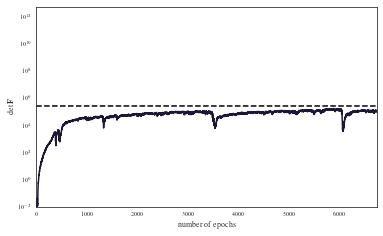

In [264]:
plt.plot(IMNN.history['detF'][:])
plt.plot(np.ones(len(IMNN.history['detF'][:]))*detF_expected, c='k', linestyle='--')
plt.ylim(1e-2, 5e12)
plt.ylabel(r'$\det \textbf{F}$')
plt.xlabel('number of epochs')
plt.yscale('log')
plt.tight_layout()
#plt.savefig('/mnt/home/tmakinen/repositories/field-plots/LN-training-20x20.png', dpi=400)

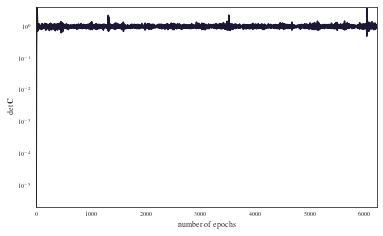

In [259]:
plt.plot(IMNN.history['detC'][:])
#plt.plot(np.ones(len(IMNN.history['detC'][:]))*detF_expected, c='k', linestyle='--')
#plt.ylim(1e-2, 5e12)
plt.ylabel(r'$\det \textbf{C}$')
plt.xlabel('number of epochs')
plt.yscale('log')
plt.tight_layout()
#plt.savefig('/mnt/home/tmakinen/repositories/field-plots/LN-training-20x20.png', dpi=400)

In [265]:
detf_imnn = np.linalg.det(IMNN.F)
print('detF_pred: ', detF_expected)
print('detF_IMNN: ', detf_imnn)
print('detF_IMNN / detF_pred : ', detf_imnn / detF_expected)

detF_pred:  264706.2
detF_IMNN:  155885.75
detF_IMNN / detF_pred :  0.58890104


### using IMNN, create sampler that goes $f: \textbf{d} \mapsto \textbf{x}$
(outputs summaries via `get_estimate`)

In [266]:
@jit #partial(jax.jit, static_argnums=0)
def get_estimate(d):
    if len(d.shape) == 1:
        return IMNN.θ_fid + np.einsum(
            "ij,kj,kl,l->i",
            IMNN.invF,
            IMNN.dμ_dθ,
            IMNN.invC,
            IMNN.model(IMNN.best_w, d, rng=rng) - IMNN.μ)
    else:
        return IMNN.θ_fid + np.einsum(
            "ij,kj,kl,ml->mi",
            IMNN.invF,
            IMNN.dμ_dθ,
            IMNN.invC,
            IMNN.model(IMNN.w, d, rng=rng) - IMNN.μ)


### obtain target data from Florent's sims

In [267]:
cd ~/repositories/FieldIMNNs/fields

/mnt/home/tmakinen/repositories/FieldIMNNs/fields


In [268]:
dataid = 1 # for florent's sims as target data

In [269]:
rng, key = jax.random.split(rng)
target = dict(
    f_NL=None,
    α=np.array(1.0),
    β=np.array(0.5))

dat = np.load("correlations_vs_field/data/Sims20_05_10_80_80_500_80_1_123456.npy")
target['f_NL'] = dat[dataid]['field'].flatten()

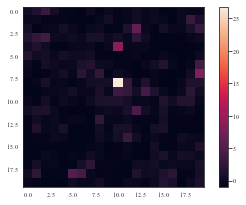

In [270]:
plt.imshow(target["f_NL"].reshape((N, N)))
plt.colorbar()

In [275]:
# put data in the proper shape for IMNN 
target_data = np.expand_dims(np.expand_dims(np.expand_dims(np.pad(target["f_NL"].reshape((N, N)), [2,2]), 0), 0), 0)
estimates = IMNN.get_estimate(target_data)

# prior

In [276]:
class uniform:
    def __init__(self, low, high):
        self.low = np.array(low)
        self.high = np.array(high)
        self.event_shape = [[] for i in range(self.low.shape[0])]
    def sample(self, n=None, seed=None):
        if n is None:
            n = 1
        keys = np.array(jax.random.split(
            seed, 
            num=len(self.event_shape)))
        return jax.vmap(
            lambda key, low, high : jax.random.uniform(
                key, 
                shape=(n,), 
                minval=low, 
                maxval=high))(
            keys, self.low, self.high)

prior = uniform([0., 0.2], [2., 0.8])

# ABC sampler

In [277]:
GAs = [GaussianApproximation(IMNN.get_estimate(target_data), IMNN.invF, prior)]

In [278]:
θ_fid

DeviceArray([0.95, 0.55], dtype=float32)

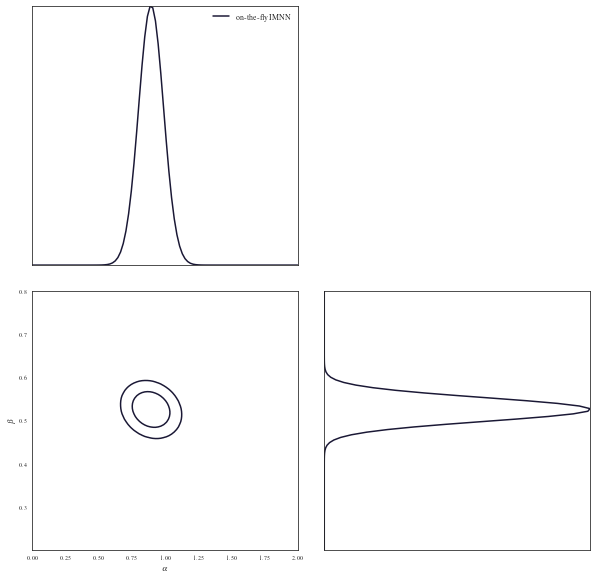

In [279]:
%matplotlib inline
for i, (GA, label) in enumerate(zip(GAs, labels)):
    if i == 0:
        ax = GA.marginal_plot(
            axis_labels=[r"$\alpha$", r"$\beta$"], label='on-the-fly IMNN', colours="C{}".format(i)
        )
    else:
        GA.marginal_plot(ax=ax, label=label, colours="C{}".format(i), ncol=8)

In [280]:
ABC = ApproximateBayesianComputation(
        target_data, prior, 
     lambda A,B : imnn_simulator(A,B, simulator_args={**simulator_args, **{'squeeze':False}}), 
                                       IMNN.get_estimate, F=IMNN.F, gridsize=50
    )

In [281]:
imnn_simulator(key, θ_fid, simulator_args={**simulator_args, **{'squeeze':True}}).shape

(1, 24, 24)

In [282]:
%%time
rng,abc_key = jax.random.split(rng)
ABC(rng=abc_key,
        n_samples=int(1e3),
        min_accepted=15000,
        max_iterations=20000,
        ϵ=0.05,
        smoothing=0.);

316 accepted in last  20000 iterations  (20000000 simulations done).
CPU times: user 9min, sys: 2.77 s, total: 9min 3s
Wall time: 9min 7s


(<imnn.utils.container.container at 0x154b59a815e0>,
 <imnn.utils.container.container at 0x154b784fc0a0>)

In [283]:
np.save('./marginals/abc_marginal_field_%d'%(dataid), ABC.parameters.accepted[0])

array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

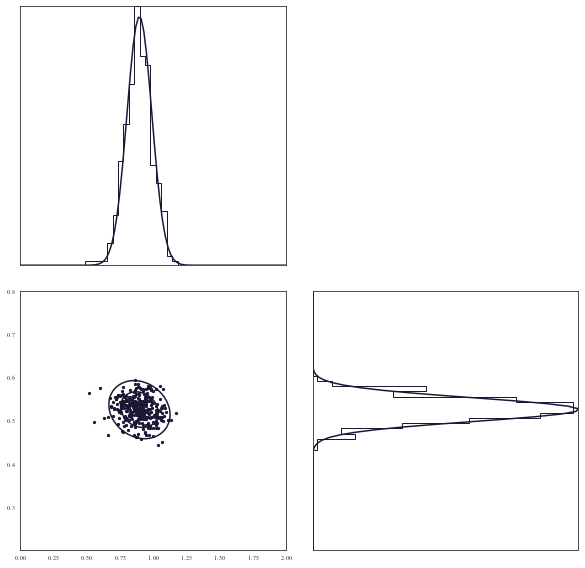

In [285]:
ax = ABC.scatter_plot()
GA.marginal_plot(ax=ax)

In [157]:
dataid

1

In [123]:
# get comparison to true posterior
# prior = uniform([0., 0.2], [2., 0.8])
# load marginals from Tom's code
size = 250
marginal = np.load('./marginals/marginal_field_%d_20x20_field.npy'%(dataid))
arr = marginal[~np.isnan(marginal)]
inds = np.argsort(arr)[::-1]
cdf = np.cumsum(arr[inds] / arr.sum())
levels = [arr[inds[np.argmin(np.abs(i - cdf))]] for i in [0.99, 0.95, 0.68, 0.]]


In [128]:
marginal

array([[nan,  0.,  0., ..., nan, nan, nan],
       [nan,  0.,  0., ..., nan, nan, nan],
       [nan,  0.,  0., ..., nan, nan, nan],
       ...,
       [nan,  0.,  0., ..., nan, nan, nan],
       [nan,  0.,  0., ..., nan, nan, nan],
       [nan,  0.,  0., ..., nan, nan, nan]])

ValueError: Contour levels must be increasing

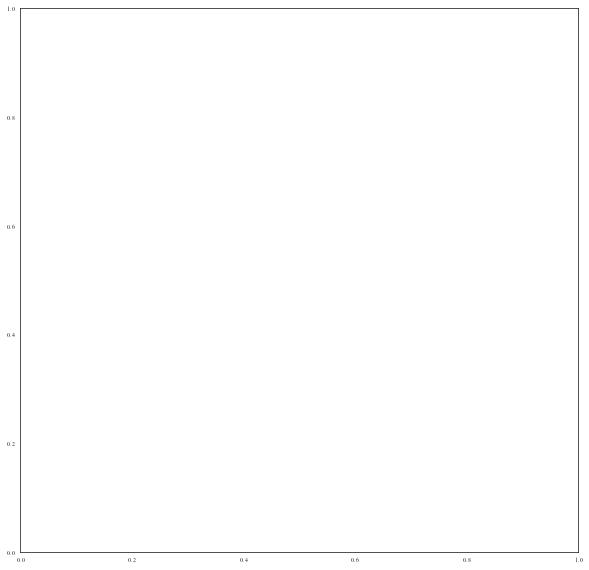

In [124]:
plt.figure(figsize=(10, 10))
plt.contourf(np.linspace(0., 2., size), np.linspace(0.2, 0.8, size), marginal.T, levels=levels, cmap="Purples")
plt.contour(np.linspace(0., 2., size), np.linspace(0.2, 0.8, size), marginal.T, levels=levels, label='DA')
plt.scatter(ABC.parameters.accepted[0], ABC.parameters.accepted[1])
plt.xlabel("α")
plt.ylabel("β")
plt.ylim(0.4, 0.6)
plt.xlim(0.5, 1.5)
plt.axvline(target["α"], linestyle="dashed", color="black")
plt.axhline(target["β"], linestyle="dashed", color="black");
#plt.savefig("IMNN_vs_BHM_field_%d.svg"%(dataid), bbox_inches="tight", transparent=True)

In [393]:
target['f_NL'].shape

(400,)

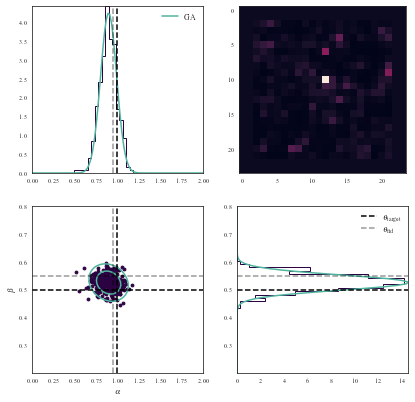

In [287]:
%matplotlib inline
#plt.style.use('default')
new_colors = [ '#2c0342', '#286d87', '#4fb49d', '#9af486']
fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(3.37*2, 3.37*2))
latexify(fig_width=3.37, fig_height=3.37)

ABC.scatter_plot(ax=ax,
                      colours=new_colors[0], 
                      axis_labels=[r"$\alpha$", r"$\beta$"], 
                      s=8,
                      label='ABC estimate')
# ABC.marginal_plot(ax=ax,
#             axis_labels=[r"$A$", r"$B$"], colours='green',
#             label='ABC marginal plot')


GAs[0].marginal_plot(ax=ax, colours=new_colors[2], axis_labels=[r"$\alpha$", r"$\beta$"], label="GA", ncol=1)
ax[0,1].imshow(np.squeeze(target_data[0, 0]))

#ax[0,1].set_title(r'$\theta_{\rm target} = A,B = (%.2f,%.2f)$'%(θ_target[0], θ_target[1]))

ax[0,0].axvline(target['α'], linestyle='--', c='k')
ax[1,0].axvline(target['α'], linestyle='--', c='k')
ax[1,0].axhline(target['β'], linestyle='--', c='k')
ax[1,1].axhline(target['β'], linestyle='--', c='k', label=r'$\theta_{\rm target}$')

ax[1,0].set_xlabel(r'$\alpha$')
ax[1,0].set_ylabel(r'$\beta$')

ax[0,0].axvline(θ_fid[0], linestyle='--', c='k', alpha=0.4)
#ax[1,0].contourf(A_range, B_range, L1.reshape((size, size)))
#ax[0, 0].plot(A_range, np.real(loglikeA), color='g', label='loglikeA')

ax[1,0].axvline(θ_fid[0], linestyle='--', c='k', alpha=0.4)
ax[1,0].axhline(θ_fid[1], linestyle='--', c='k', alpha=0.4)
ax[1,1].axhline(θ_fid[1], linestyle='--', c='k', alpha=0.4, label=r'$\theta_{\rm fid}$')

ax[1,1].legend(framealpha=0.)


# add in the likelihood estimate
# ax[0, 0].plot(A_range, likelihoodA, color='#FF8D33', label=None)
# ax[0, 1].axis("off")
# ax[1, 0].contour(A_range, B_range, np.real(likelihood), levels=value, colors='#FF8D33')
# ax[1, 1].plot(likelihoodB, B_range, color='#FF8D33', label='loglike')

ax[0,0].legend(framealpha=0.)

#plt.savefig('/mnt/home/tmakinen/repositories/field-plots/LN-20x20-contours.png', dpi=400)
#plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [ ]:
def ConditionalMaskedAutoregressiveFlow(
    n_parameters, n_data, n_mades=1, n_hidden=[50,50], input_order="random",
    activation=tf.keras.layers.LeakyReLU(0.01), all_layers=True,
    kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1e-5, seed=None), bias_initializer='zeros',
    kernel_regularizer=None, bias_regularizer=None, kernel_constraint=None,
    bias_constraint=None):
    """
    Conditional Masked Autoregressive Flow.
    """
    if all_layers == True:
        all_layers = "all_layers"
    else:
        all_layers = "first_layer"
    # construct stack of MADEs
    MADEs = [tfb.MaskedAutoregressiveFlow(
                shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
                    params=2,
                    hidden_units=n_hidden,
                    activation=activation,
                    event_shape=[n_data],
                    conditional=True,
                    conditional_event_shape=[n_parameters],
                    conditional_input_layers=all_layers,
                    input_order=input_order,
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer,
                    kernel_regularizer=kernel_regularizer,
                    bias_regularizer=bias_regularizer,
                    kernel_constraint=kernel_constraint,
                    bias_constraint=bias_constraint),
                name="MADE_{}".format(i))
             for i in range(n_mades)]
    bijector = tfb.Chain(MADEs)
    distribution = tfd.TransformedDistribution(
        distribution=tfd.Normal(loc=0., scale=1.),
        bijector=bijector,
        event_shape=[n_data])
    put_conditional = lambda conditional : dict(
        zip(["MADE_{}".format(i) for i in range(n_mades)], 
            [{"conditional_input": tf.convert_to_tensor(conditional, dtype=tf.float32)} for i in range(n_mades)]))
    distribution.conditional_log_prob = lambda a, conditional : distribution.log_prob(a, bijector_kwargs=put_conditional(conditional))
    distribution.conditional_prob = lambda a, conditional : distribution.prob(a, bijector_kwargs=put_conditional(conditional))
    distribution.conditional_sample = lambda a, conditional : distribution.sample(a, bijector_kwargs=put_conditional(conditional))
    _ = distribution.conditional_log_prob(np.random.normal(0, 1, (1, n_data)),
                                          conditional=np.random.normal(0, 1, (1, n_parameters)))
    return distribution

In [ ]:
distribution.log_prob(target, bijector_kwargs=put_conditional(parameters))